In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow as tf
import re
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Lambda, Dense, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing import image


In [2]:
import tensorflow as tf

In [3]:
tf.__version__    #2.16.1

'2.13.1'

In [3]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

base_path  = './data/'

categories = {
    0: 'battery', 1: 'clothes', 2: 'glass', 3: 'metal', 
    4: 'organic', 5: 'paper', 6: 'plastic', 7: 'shoes'
}

In [4]:
df = pd.read_csv('./data/waste_classification.csv')
print('Number of elements =', len(df))

Number of elements = 23871


In [5]:
df.head()

,filename,category,category_name
0,clothes/clothes4968.jpg,1,clothes
1,organic/organic_011260_photo.jpg,4,organic
2,plastic/R_597.jpg,6,plastic
3,clothes/clothes4851.jpg,1,clothes
4,organic/organic_001994_photo.jpg,4,organic


clothes/clothes2220.jpg


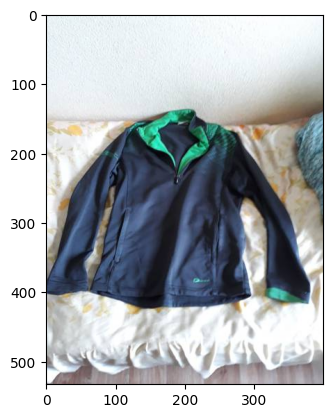

In [8]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

In [9]:
mobilenetv2_layer = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS),
    weights='imagenet',
    pooling='avg'
)

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False

# Create a custom layer to apply preprocessing
def mobilenetv2_preprocessing(img):
    return tf.keras.applications.mobilenet_v2.preprocess_input(img)

model_input = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))
x = Lambda(mobilenetv2_preprocessing)(model_input)
x = mobilenetv2_layer(x)

x = Dense(50,activation='relu')(x)
output = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=model_input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 50)                64050     
                                                                 
 dense_1 (Dense)             (None, 8)                 408       
                                                                 
Total params: 2322442 (8.86 MB)
Trainable params: 64458 (251.79 KB)
Non-trainable params: 2257984 (8.61 MB)
___________________

In [10]:
# Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# Split the data into train, validation, and test sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('Train size =', total_train, 'Validate size =', total_validate, 'Test size =', test_df.shape[0])

Train size = 19096 Validate size = 2387 Test size = 2388


In [11]:
batch_size = 64
EPOCHS = 4

In [12]:
# Create data pipelines using tf.data API
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 19096 validated image filenames belonging to 8 classes.
Found 2387 validated image filenames belonging to 8 classes.


In [13]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_validate // batch_size,
)

Epoch 1/4
298/298 [==============================] - 311s 1s/step - loss: 0.5215 - categorical_accuracy: 0.8278 - val_loss: 0.3370 - val_categorical_accuracy: 0.8915
Epoch 2/4
298/298 [==============================] - 314s 1s/step - loss: 0.3565 - categorical_accuracy: 0.8817 - val_loss: 0.3089 - val_categorical_accuracy: 0.9050
Epoch 3/4
298/298 [==============================] - 291s 974ms/step - loss: 0.3269 - categorical_accuracy: 0.8938 - val_loss: 0.2869 - val_categorical_accuracy: 0.9058
Epoch 4/4
298/298 [==============================] - 291s 976ms/step - loss: 0.3091 - categorical_accuracy: 0.8970 - val_loss: 0.3075 - val_categorical_accuracy: 0.9016


In [14]:
model.save("models/mobilenetv2/model01_batch_04")

INFO:tensorflow:Assets written to: models/mobilenetv2/model01_batch_04\assets


INFO:tensorflow:Assets written to: models/mobilenetv2/model01_batch_04\assets


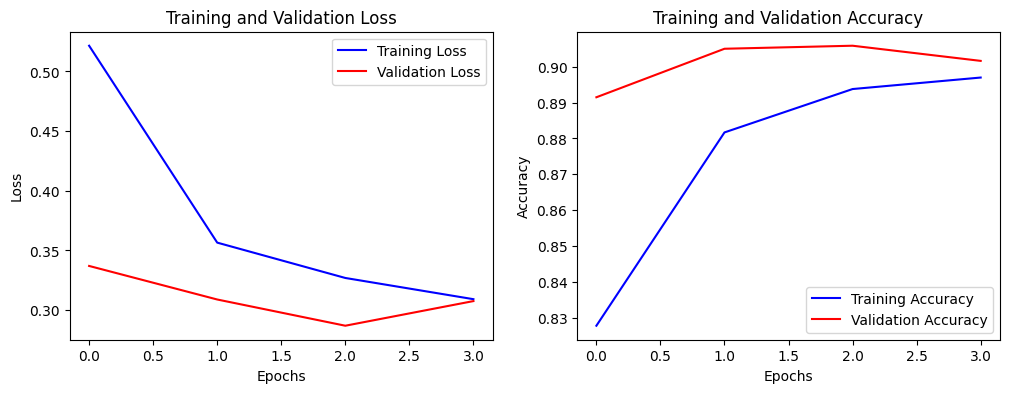

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.savefig('./output/mobilenetv2_model01_batch_04.png')
plt.show()

In [16]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Accuracy on test set =', round((accuracy * 100), 2), '%')

Found 2388 validated image filenames belonging to 8 classes.
2388/2388 [==============================] - 33s 14ms/step - loss: 0.3156 - categorical_accuracy: 0.9003
Accuracy on test set = 90.03 %


In [17]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated its own dictionary and it has assigned different numbers to our categories, and the predictions made by the model
# will be made using the generator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v, k) for k, v in gen_label_map.items())
print(gen_label_map)

# Get the model's predictions for the test set
preds = model.predict(test_generator, steps=nb_samples)

# Get the category with the highest predicted probability; the prediction is only the category's number and not the name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas DataFrame to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

{0: 'battery', 1: 'clothes', 2: 'glass', 3: 'metal', 4: 'organic', 5: 'paper', 6: 'plastic', 7: 'shoes'}
2388/2388 [==============================] - 34s 14ms/step
              precision    recall  f1-score   support

     battery       0.93      0.88      0.90       118
     clothes       0.97      0.98      0.97       550
       glass       0.72      0.92      0.81       246
       metal       0.84      0.78      0.81       174
     organic       0.94      0.93      0.93       582
       paper       0.92      0.87      0.89       236
     plastic       0.89      0.73      0.81       297
       shoes       0.92      0.96      0.94       185

    accuracy                           0.90      2388
   macro avg       0.89      0.88      0.88      2388
weighted avg       0.91      0.90      0.90      2388



clothes/clothes441.jpg
1/1 [==============================] - 0s 29ms/step
[[2.2433252e-08 9.9975485e-01 5.8718597e-05 2.1463607e-06 6.5542132e-05
  1.4663202e-06 4.0619030e-05 7.6638360e-05]]
1
clothes


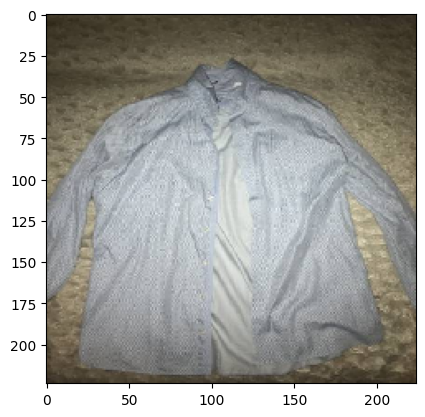

In [76]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
img_path = base_path +sample['filename']
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

print(sample['filename'])
plt.imshow(img)

preds = model.predict(x)
print(preds)

preds_max=np.argmax(preds)
print(preds_max)
print(categories[preds_max])

In [77]:
batch_size = 64
EPOCHS2 = 6

In [78]:
history2 = model.fit(
    train_generator,
    epochs=EPOCHS2,
    validation_data=validation_generator,
    steps_per_epoch=total_train // batch_size,
    validation_steps=total_validate // batch_size,
)

Epoch 1/6
298/298 [==============================] - 302s 1s/step - loss: 0.2872 - categorical_accuracy: 0.9024 - val_loss: 0.2959 - val_categorical_accuracy: 0.9037
Epoch 2/6
298/298 [==============================] - 325s 1s/step - loss: 0.2778 - categorical_accuracy: 0.9072 - val_loss: 0.2843 - val_categorical_accuracy: 0.9101
Epoch 3/6
298/298 [==============================] - 309s 1s/step - loss: 0.2646 - categorical_accuracy: 0.9108 - val_loss: 0.2810 - val_categorical_accuracy: 0.9092
Epoch 4/6
298/298 [==============================] - 310s 1s/step - loss: 0.2509 - categorical_accuracy: 0.9158 - val_loss: 0.2790 - val_categorical_accuracy: 0.9117
Epoch 5/6
298/298 [==============================] - 311s 1s/step - loss: 0.2446 - categorical_accuracy: 0.9150 - val_loss: 0.2881 - val_categorical_accuracy: 0.9020
Epoch 6/6
298/298 [==============================] - 303s 1s/step - loss: 0.2322 - categorical_accuracy: 0.9212 - val_loss: 0.2661 - val_categorical_accuracy: 0.9181


In [79]:
model.save("models/mobilenetv2/model01_batch_10")

INFO:tensorflow:Assets written to: models/mobilenetv2/model01_batch_10\assets


INFO:tensorflow:Assets written to: models/mobilenetv2/model01_batch_10\assets


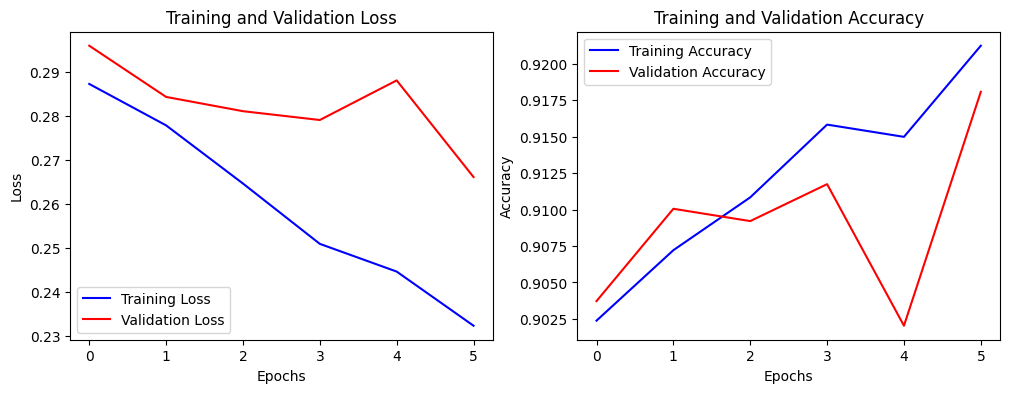

In [80]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Validation Loss', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history2.history['categorical_accuracy'], label='Training Accuracy', color='blue')
plt.plot(history2.history['val_categorical_accuracy'], label='Validation Accuracy', color='red')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.savefig('./output/mobilenetv2_model01_batch_10.png')
plt.show()

In [81]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate(test_generator, steps=nb_samples)

print('Accuracy on test set =', round((accuracy * 100), 2), '%')

Found 2388 validated image filenames belonging to 8 classes.
2388/2388 [==============================] - 36s 15ms/step - loss: 0.2782 - categorical_accuracy: 0.9095
Accuracy on test set = 90.95 %


In [82]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated its own dictionary and it has assigned different numbers to our categories, and the predictions made by the model
# will be made using the generator's dictionary.

gen_label_map = test_generator.class_indices
gen_label_map = dict((v, k) for k, v in gen_label_map.items())
print(gen_label_map)

# Get the model's predictions for the test set
preds = model.predict(test_generator, steps=nb_samples)

# Get the category with the highest predicted probability; the prediction is only the category's number and not the name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas DataFrame to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

{0: 'battery', 1: 'clothes', 2: 'glass', 3: 'metal', 4: 'organic', 5: 'paper', 6: 'plastic', 7: 'shoes'}
2388/2388 [==============================] - 35s 15ms/step
              precision    recall  f1-score   support

     battery       0.96      0.87      0.92       118
     clothes       0.96      0.98      0.97       550
       glass       0.84      0.83      0.84       246
       metal       0.78      0.88      0.82       174
     organic       0.95      0.93      0.94       582
       paper       0.86      0.93      0.90       236
     plastic       0.87      0.80      0.83       297
       shoes       0.94      0.94      0.94       185

    accuracy                           0.91      2388
   macro avg       0.90      0.90      0.89      2388
weighted avg       0.91      0.91      0.91      2388



shoes/shoes1294.jpg
1/1 [==============================] - 0s 31ms/step
[[6.4465064e-05 3.8356194e-03 9.8385417e-04 2.1191868e-03 2.3577880e-02
  6.6451114e-03 1.8942945e-04 9.6258450e-01]]
7
shoes


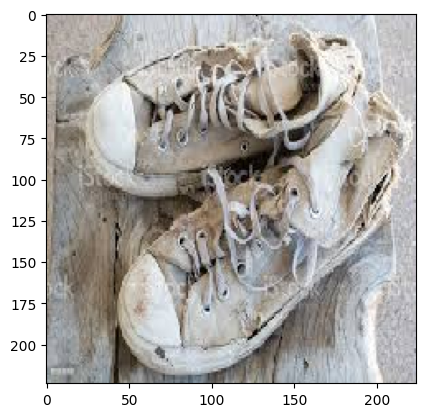

In [83]:
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
img_path = base_path +sample['filename']
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

print(sample['filename'])
plt.imshow(img)

preds = model.predict(x)
print(preds)

preds_max=np.argmax(preds)
print(preds_max)
print(categories[preds_max])